# 4 测试全部的用户

In [1]:
# 导入常用库
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time
from copy import deepcopy 
from tqdm import tqdm
% matplotlib inline

import networkx as nx
from networkx.algorithms import bipartite

In [2]:
path = './ml-100k/'
# 读入数据
names = ['user_id', 'item_id', 'rating', 'timestamp']
df_train = pd.read_csv(path+'u1.base', sep='\t', names=names)
df_test = pd.read_csv(path+'u1.test', sep='\t', names=names)
print len(df_train)
print len(df_test)

80000
20000


In [3]:
def preprocess(data):
    data['u_user_id'] = data['user_id'].map(lambda x: 'u'+str(x))
    data['i_item_id'] = data['item_id'].map(lambda x: 'i'+str(x))
    data['edges'] = data.apply(lambda x: (x['u_user_id'], x['i_item_id']), axis = 1)
    # 获得 user 节点，以及 item 节点
    user_ids = data.u_user_id.unique().tolist()
    item_ids = data.i_item_id.unique().tolist()
    edges = data.edges.unique().tolist()
    print 'user_ids : {}'.format(len(user_ids))
    print 'item_ids : {}'.format(len(item_ids))
    
    B = nx.Graph()
    B.add_nodes_from(user_ids, bipartite=0)
    B.add_nodes_from(item_ids, bipartite=1)
    B.add_edges_from(edges)
    print nx.is_connected(B)
    return B

In [4]:
def train(G, alpha, root):
    rank = {x:0 for x in G.nodes}
    rank[root] = 1
    for k in range(20):
        tmp = {x:0 for x in G.nodes}
        for i in G.nodes:
            for j in G.neighbors(i):
                if j not in tmp:
                    tmp[j] = 0
                tmp[j] += alpha * rank[i] / len(list(G.neighbors(i)))
                if j == root:
                    tmp[j] += 1 - alpha
        rank = tmp
    return rank

def predict(data, rank, user, top_k):
    connect_item = [item_id for item_id in list(set(data[data['u_user_id'] == user]['i_item_id']))]
    recommend_item = [(key, rank[key]) for key in rank if key not in connect_item and 'u' not in key]
    top_k_item = sorted(recommend_item, key=lambda x: x[1], reverse=True)[:top_k]
    return top_k_item

In [5]:
def precision(test, user, top_k_item):
    r_all = len(top_k_item)
    if r_all != 0:
        recom_list = [int(key[0][1:]) for key in top_k_item]
        data = test[test.u_user_id==user]
        r = len(data[(data.item_id.isin(recom_list))].item_id.unique())
        p = r*1.0/r_all
        return p
    else:
        return -2

def recall(test, user ,top_k_item):
    tu = test[test.u_user_id == user]['item_id'].nunique()
    if tu != 0:
        recom_list = [int(key[0][1:]) for key in top_k_item]
        data = test[test.u_user_id==user]
        r = len(data[(data.item_id.isin(recom_list))].item_id.unique())
        rec = r*1.0/tu
        return rec
    else:
        return -2

In [6]:
B_train = preprocess(df_train)
B_test = preprocess(df_test)

user_ids : 943
item_ids : 1650
True
user_ids : 459
item_ids : 1410
True


In [7]:
# 获取 user 集合
user_list = df_train.u_user_id.unique().tolist()
rec = []
pre = []
G = deepcopy(B_train)
begin_time = time.time()
for user in tqdm(user_list):
    item_ids = df_test[df_test.u_user_id == user].i_item_id.unique().tolist()
    # 注意，每次传入的B_train都是新的，否则容易把 test 的边引入进来
    # 例如， user1 和 user2 都对 test 的 item1 相连，如果测试 user1 时，添加进了
    # （user2，item1）边，则在测试 user2 时，此边就变成已存在的，无法删除
    B_train = deepcopy(G)
    B_train.add_nodes_from(item_ids, bipartite=1)
    edges = df_test[(df_test.i_item_id.isin(item_ids) & (df_test.u_user_id != user))].edges.unique().tolist()
    B_train.add_edges_from(edges)
    if(nx.is_connected(B_train)):
        rank = train(B_train, 0.6, user)
        # top_k 的值取 train 里面相连的 1/4
        top_k = int(len(list(B_train.neighbors(user)))/4)
        top_k_item = predict(df_train, rank, user, top_k)
        p = precision(df_test, user, top_k_item) 
        r = recall(df_test, user, top_k_item)
        rec.append(r)
        pre.append(p)
    else:
        rec.append(-1)
        pre.append(-1)
        
        
end_time = time.time()
print "用时 ： {}".format(end_time-begin_time)

100%|██████████████████████████████████████████████████████████████████████████████| 943/943 [2:02:15<00:00,  7.78s/it]


用时 ： 7335.99399996


In [8]:
result = pd.DataFrame({'u_user_id':user_list, 'pre':pre, 'rec':rec})
result.to_csv("result.csv", index=None)

In [9]:
result.head()

,pre,rec,u_user_id
0,0.757576,0.182482,u1
1,0.400000,0.181818,u2
2,0.571429,0.153846,u3
3,0.666667,0.200000,u4
4,0.590909,0.154762,u5


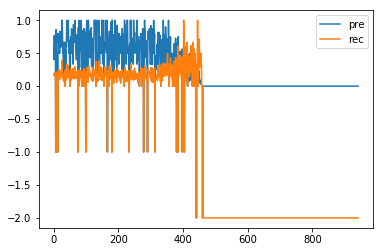

In [10]:
result[['pre','rec']].plot()

从绘图的结果来看，id 靠前的用户，精确率一般大于召回率。这是由于我们推荐的TOP K中，K值过小（一般是正常的1/4），如果提高 K 值，则会提高召回率，但是会降低精确率。

id 大于 400 的用户，他们的度比较小，因此大部分都没有计算，在函数里直接返回-2，而有些添加对应的边之后，图不是连通的，直接返回-1

In [26]:
# 查看一下各个点的度
degree = [[int(n[1:]),d] for n, d in G.degree() if 'i' not in n]
degree = np.array(degree).reshape(-1,2)
degree = pd.DataFrame({'user_id':degree[:,0], 'degree_num':degree[:,1]}).sort_values(by=['user_id']).reset_index()[['user_id','degree_num']]
degree.head()

,user_id,degree_num
0,1,135
1,2,40
2,3,28
3,4,14
4,5,91


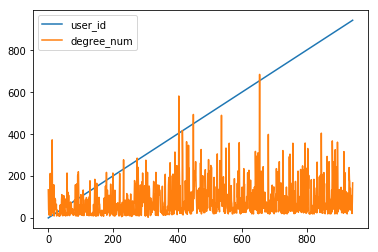

In [27]:
degree.plot()

   user_id  degree_num
0        1         137
1        2          22
2        3          26
3        4          10
4        5          84


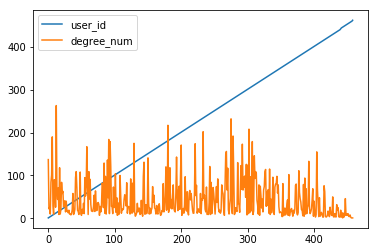

In [28]:
# 查看一下各个点的度
degree_test = [[int(n[1:]),d] for n, d in B_test.degree() if 'i' not in n]
degree_test = np.array(degree_test).reshape(-1,2)
degree_test = pd.DataFrame({'user_id':degree_test[:,0], 'degree_num':degree_test[:,1]}).sort_values(by=['user_id']).reset_index()[['user_id','degree_num']]
print(degree_test.head())
degree_test.plot()

从这个图中就可以看出问题出在了 test 的数据上，在 user_id 大于 400 的有一部缺失值